In [1]:
# MP_work_notebook

In [1]:
from alpaca.data.historical import CryptoHistoricalDataClient

# No keys required for crypto data
client = CryptoHistoricalDataClient()

In [2]:
import alpaca_trade_api as tradeapi
import pandas as pd
import pandas_ta as ta
import numpy as np
# import mplfinance as mpf
import matplotlib.pyplot as plt

#Loading Alpaca API keys
API_Key = "PK688IQ8GKXYNUE4M7YX"
API_secret_key = "LKfuASkhgHQm6xnD6em7CHrZbPoB8Nt7Pabo0jPZ"
API_base_url = "https://paper-api.alpaca.markets"
api = tradeapi.REST(API_Key, API_secret_key, API_base_url, api_version='v2')

In [3]:
from alpaca.data.requests import CryptoBarsRequest
from alpaca.data.timeframe import TimeFrame

# user input for the ticker and date range
crypto_input = input("Enter the cryptocurrency symbols (e.g., BTC, ETH, DOGE, LTC): ")
crypto_list = [f"{ticker.strip()}/USD" for ticker in crypto_input.split(",")]  # Format as f-string

start_year = input("Enter the start year (YYYY): ")
start_month = input("Enter the start month (MM): ")
start_day = input("Enter the start day (DD): ")

end_year = input("Enter the end year (YYYY): ")
end_month = input("Enter the end month (MM): ")
end_day = input("Enter the end day (DD): ")

# Construct start and end date strings
start_date = f"{start_year}-{start_month}-{start_day}"
end_date = f"{end_year}-{end_month}-{end_day}"

# Creating request object
request_params = CryptoBarsRequest(
    symbol_or_symbols=crypto_list,  # Use the formatted list of tickers
    timeframe=TimeFrame.Day,
    start=start_date,
    end=end_date
)

Enter the cryptocurrency symbols (e.g., BTC, ETH, DOGE, LTC):  BTC, ETH, DOGE, LTC
Enter the start year (YYYY):  2023
Enter the start month (MM):  01
Enter the start day (DD):  01
Enter the end year (YYYY):  2024
Enter the end month (MM):  09
Enter the end day (DD):  09


In [4]:
# request_params

In [5]:
# Retrieve daily bars for Bitcoin in a DataFrame and printing it
crypto_bars = client.get_crypto_bars(request_params)
# Convert to dataframe
crypto_df = crypto_bars.df.reset_index()

#Format and clean datafame
crypto_df.loc[:,'date'] = pd.to_datetime(crypto_df.loc[:,'timestamp']).dt.date
clean_crypto_df = crypto_df.copy()[['symbol', 'date', 'open', 'close', 'volume']]
#clean_crypto_df

In [8]:
# Get unique symbols from the DataFrame
unique_symbols = clean_crypto_df['symbol'].unique()

# Create a dictionary to hold separate DataFrames for each unique symbol
clean_crypto_dfs = {}

# Loop through each unique symbol and create a DataFrame for it
for symbol in unique_symbols:
    # Create a valid variable name
    variable_name = symbol.replace('/', '_')  # Replace '/' with '_' to create a valid variable name
    globals()[f"{variable_name}_df"] = clean_crypto_df[crypto_df['symbol'] == symbol].reset_index(drop=True)
    crypto_df_calc = globals()[f"{variable_name}_df"]
    locals()[f"crypto_df_{variable_name}"] = crypto_df_calc
    print(f"\nDataFrame for {variable_name}:\n", locals()[f"crypto_df_{variable_name}"])


DataFrame for BTC_USD:
       symbol        date       open       close       volume
0    BTC/USD  2023-01-01  16525.000  16642.7800  1651.559057
1    BTC/USD  2023-01-02  16644.370  16718.8200  2285.656433
2    BTC/USD  2023-01-03  16721.010  16850.5900  3790.536364
3    BTC/USD  2023-01-04  16852.620  16840.5000  4847.939963
4    BTC/USD  2023-01-05  16838.470  16803.4700  2580.410943
..       ...         ...        ...         ...          ...
612  BTC/USD  2024-09-04  56689.123  57216.1885     2.616058
613  BTC/USD  2024-09-05  57187.797  56632.7325     0.818696
614  BTC/USD  2024-09-06  56638.500  54044.1175     5.045418
615  BTC/USD  2024-09-07  54058.535  54491.9085     2.060127
616  BTC/USD  2024-09-08  54523.217  54845.6950     0.327968

[617 rows x 5 columns]

DataFrame for DOGE_USD:
        symbol        date      open     close        volume
0    DOGE/USD  2023-01-01  0.069400  0.070200  1.474223e+07
1    DOGE/USD  2023-01-02  0.070200  0.071900  2.981534e+07
2    DOGE/USD

In [10]:
# Create ???_df_calc for each df
for symbol in unique_symbols:
    variable_name = symbol.replace('/', '_')  # Replace '/' with '_' to create a valid variable name
    crypto_df_calc = globals()[f"{variable_name}_df"]

    #Run calculations
    crypto_first_open = crypto_df_calc['open'].iloc[0]
    crypto_close = crypto_df_calc['close']
    crypto_open = crypto_df_calc['open']
    price_change = ((crypto_close - crypto_first_open) / crypto_first_open) * 100
    prev_close = crypto_df_calc['close'].shift(1)
    daily_change = ((crypto_close - prev_close) / prev_close) * 100
    weights = crypto_df_calc['close']
    volume = crypto_df_calc['volume']
    average_volume_crypto = (volume * weights).sum() / weights.sum()
    volume_change = (((volume - average_volume_crypto) / average_volume_crypto) * 100)
    
    # to decrease the volume change range to manageable levels
    sqrt_volume_change = np.sqrt(np.abs(volume_change))

    # to retain the sign of the original volume change (positive or negative), you can reapply the sign
    sqrt_volume_change = np.sign(volume_change) * sqrt_volume_change

    # Use .loc[] to assign the new calculated columns
    crypto_df_calc.loc[:,'price change %'] = price_change
    crypto_df_calc.loc[:,'daily change %'] =  daily_change
    crypto_df_calc.loc[:,'vol_vs_average %'] = sqrt_volume_change 
   
    locals()[f"crypto_df_{variable_name}"] = crypto_df_calc
    
    print(f"\nDataFrame for {variable_name}:\n", locals()[f"crypto_df_{variable_name}"])


DataFrame for BTC_USD:
       symbol        date       open       close       volume  price change %  \
0    BTC/USD  2023-01-01  16525.000  16642.7800  1651.559057        0.712738   
1    BTC/USD  2023-01-02  16644.370  16718.8200  2285.656433        1.172890   
2    BTC/USD  2023-01-03  16721.010  16850.5900  3790.536364        1.970287   
3    BTC/USD  2023-01-04  16852.620  16840.5000  4847.939963        1.909228   
4    BTC/USD  2023-01-05  16838.470  16803.4700  2580.410943        1.685144   
..       ...         ...        ...         ...          ...             ...   
612  BTC/USD  2024-09-04  56689.123  57216.1885     2.616058      246.240172   
613  BTC/USD  2024-09-05  57187.797  56632.7325     0.818696      242.709425   
614  BTC/USD  2024-09-06  56638.500  54044.1175     5.045418      227.044584   
615  BTC/USD  2024-09-07  54058.535  54491.9085     2.060127      229.754363   
616  BTC/USD  2024-09-08  54523.217  54845.6950     0.327968      231.895280   

     daily cha

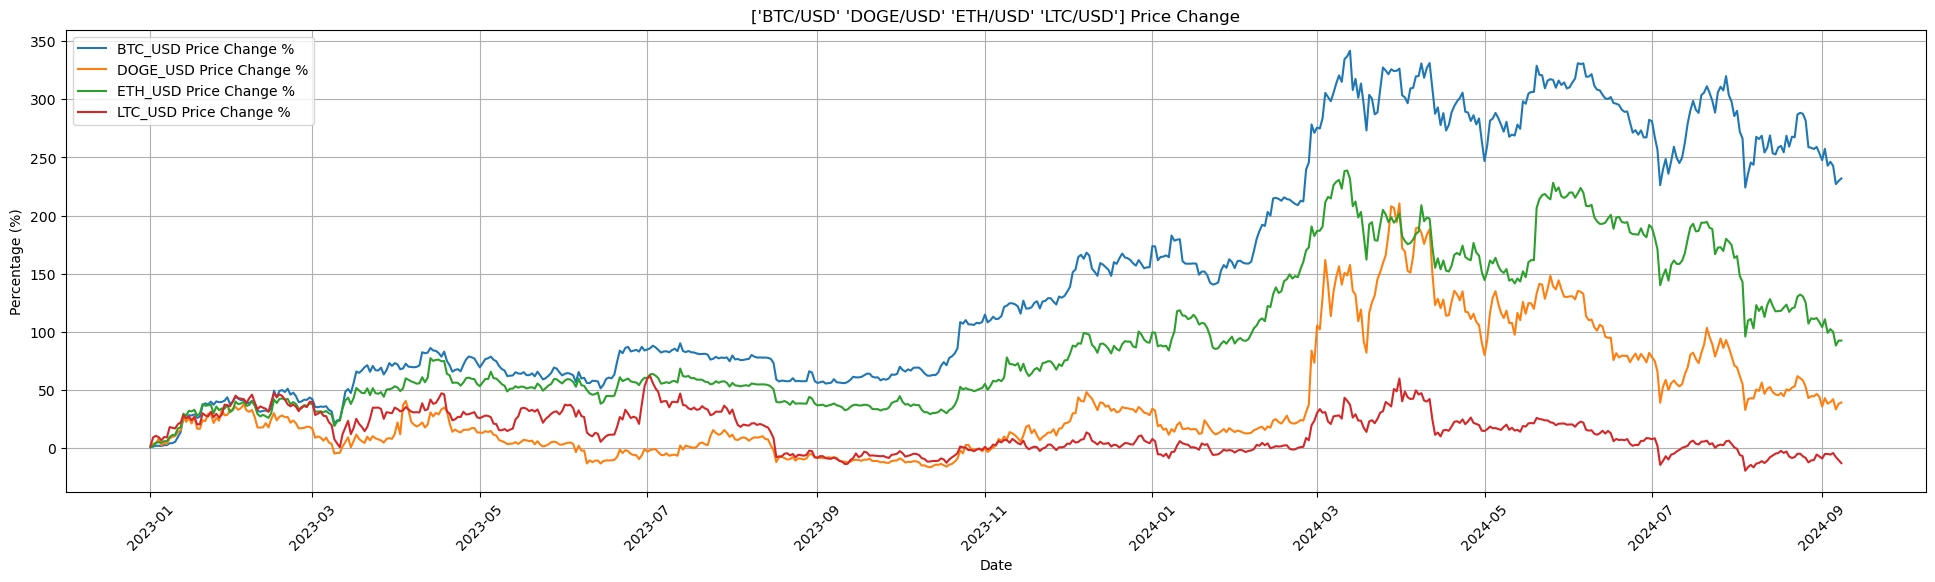

In [11]:
# Create a figure and axis for plotting
plt.figure(figsize=(24, 6))

for symbol in unique_symbols:
    variable_name = symbol.replace('/', '_')  # Replace '/' with '_' to create a valid variable name

    plt.plot(locals()[f"crypto_df_{variable_name}"]['date'], 
             locals()[f"crypto_df_{variable_name}"]['price change %'], 
             label=f'{variable_name} Price Change %')
   
# Adding titles and labels
plt.title(f'{unique_symbols} Price Change')
plt.xlabel('Date')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()  # Show legend
plt.grid()  # Show grid

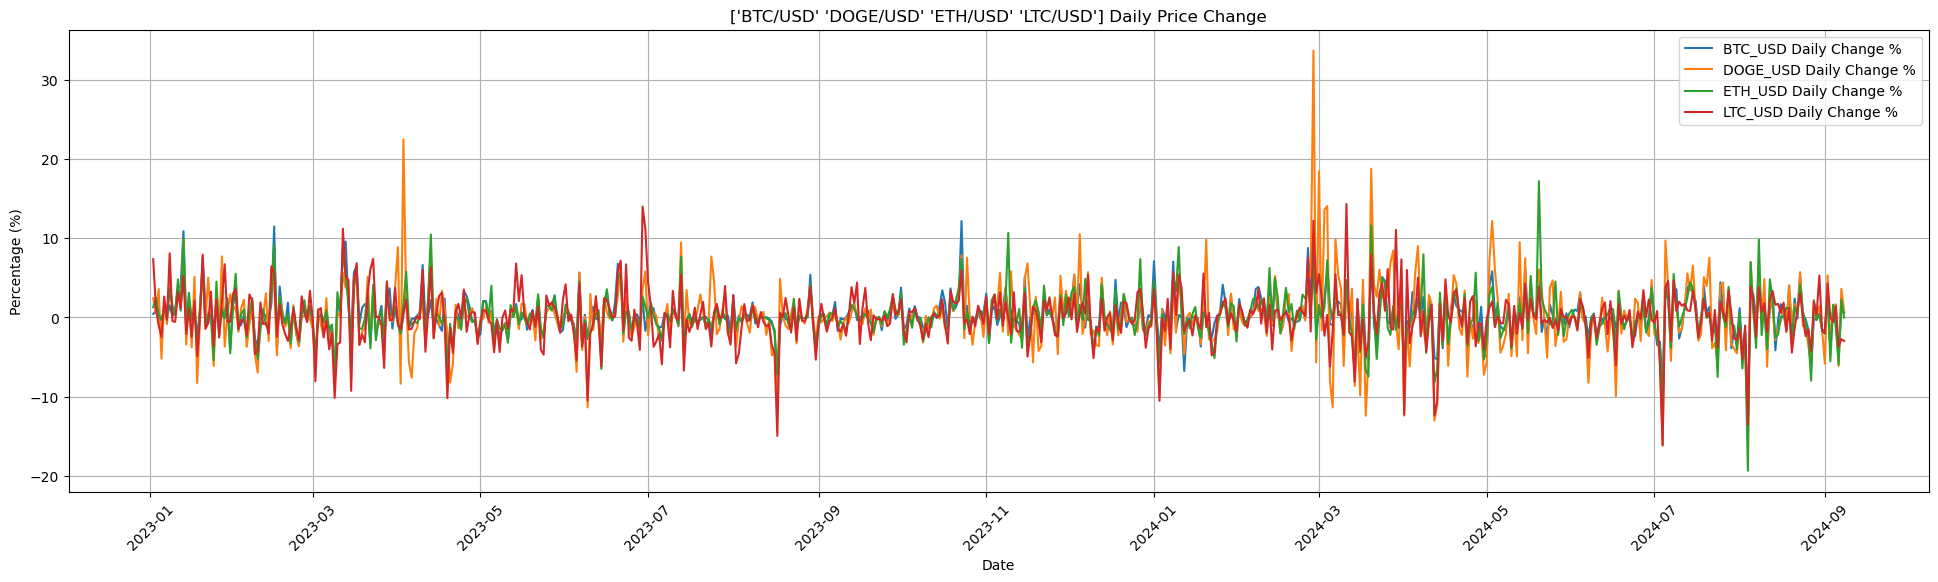

In [12]:
# Create a figure and axis for plotting
plt.figure(figsize=(24, 6))

for symbol in unique_symbols:
    variable_name = symbol.replace('/', '_')  # Replace '/' with '_' to create a valid variable name

    plt.plot(locals()[f"crypto_df_{variable_name}"]['date'], 
             locals()[f"crypto_df_{variable_name}"]['daily change %'], 
             label=f'{variable_name} Daily Change %')
   
# Adding titles and labels
plt.title(f'{unique_symbols} Daily Price Change')
plt.xlabel('Date')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()  # Show legend
plt.grid()  # Show grid

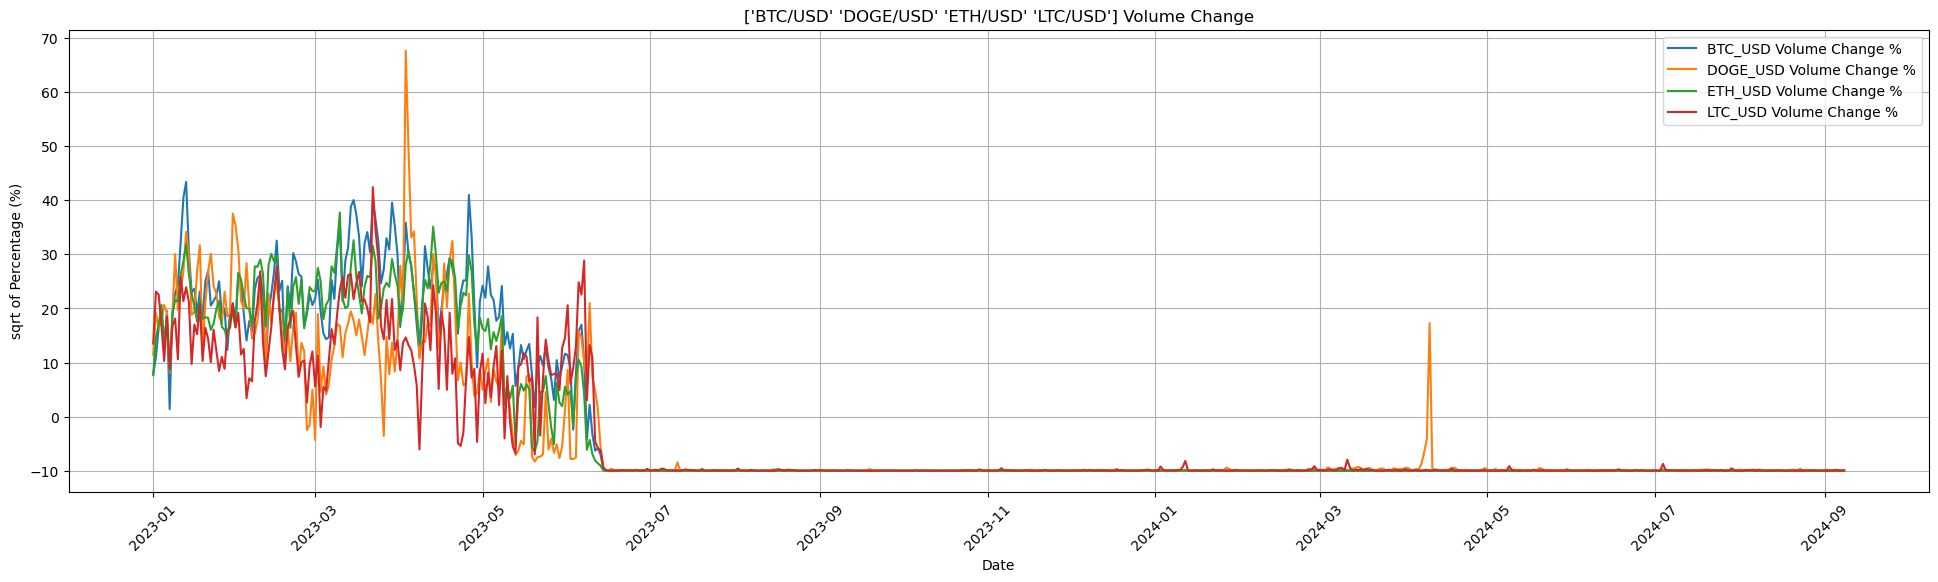

In [13]:
# Create a figure and axis for plotting
plt.figure(figsize=(24, 6))

for symbol in unique_symbols:
    variable_name = symbol.replace('/', '_')  # Replace '/' with '_' to create a valid variable name

    plt.plot(locals()[f"crypto_df_{variable_name}"]['date'], 
             locals()[f"crypto_df_{variable_name}"]['vol_vs_average %'], 
             label=f'{variable_name} Volume Change %')
   
# Adding titles and labels
plt.title(f'{unique_symbols} Volume Change')
plt.xlabel('Date')
plt.ylabel('sqrt of Percentage (%)')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()  # Show legend
plt.grid()  # Show grid

In [14]:
# user input for the ticker 
ticker_input = input("Enter the Stock symbols (e.g., NVDA, AMD, TSM, INTC): ")
ticker_list = [f"{ticker.strip()}" for ticker in ticker_input.split(",")]  # Format as f-string
# print(ticker_list)

Enter the Stock symbols (e.g., NVDA, AMD, TSM, INTC):  NVDA, AMD, TSM, INTC


In [17]:
def fetch_data(ticker_list, start_date, end_date, timeframe='1D'):
    all_data = []  # To hold DataFrames for all symbols
    
    for symbol in ticker_list:
        # Fetching bar data from Alpaca
        barset = api.get_bars(symbol, timeframe, start=start_date, end=end_date)
        
        # Convert the barset to a DataFrame
        bars_df = pd.DataFrame([{
            'ticker': symbol,
            'time': bar.t.strftime('%Y-%m-%d %H:%M:%S'),  # Converting timestamp to string
            'open': bar.o,
            'high': bar.h,
            'low': bar.l,
            'close': bar.c,
            'volume': bar.v
        } for bar in barset])

        # Append this symbol's DataFrame to the list
        all_data.append(bars_df)

    # Concatenate all individual DataFrames into one
    combined_df = pd.concat(all_data, ignore_index=True)

    return combined_df

# List of tickers
# print(ticker_list) 

# Fetching data and returning as a DataFrame
stock_df = fetch_data(ticker_list, start_date, end_date)

# Dynamically create DataFrames for each symbol
for symbol in ticker_list:
    variable_name = symbol.replace('/', '_')  # Replace '/' with '_' to create a valid variable name
    stock_df.loc[:,'date'] = pd.to_datetime(stock_df.loc[:,'time']).dt.date
    clean_stock_df = stock_df.copy()[['ticker', 'date', 'open', 'close', 'volume']]
    globals()[f"{variable_name}_df"] = clean_stock_df[clean_stock_df['ticker'] == symbol]
    print(f"\nDataFrame for {symbol}:\n", globals()[f"{variable_name}_df"])


DataFrame for NVDA:
     ticker        date     open   close     volume
0     NVDA  2023-01-03  148.510  143.15   41810749
1     NVDA  2023-01-04  145.670  147.49   45047174
2     NVDA  2023-01-05  144.910  142.65   41702951
3     NVDA  2023-01-06  144.740  148.59   43123117
4     NVDA  2023-01-09  152.840  156.28   52588232
..     ...         ...      ...     ...        ...
418   NVDA  2024-09-03  116.010  108.00  477155100
419   NVDA  2024-09-04  105.410  106.21  372470291
420   NVDA  2024-09-05  104.985  107.21  306850696
421   NVDA  2024-09-06  108.040  102.83  413638098
422   NVDA  2024-09-09  104.880  106.47  273912015

[423 rows x 5 columns]

DataFrame for AMD:
     ticker        date     open   close    volume
423    AMD  2023-01-03   65.998   64.02  48737338
424    AMD  2023-01-04   65.000   64.66  49627944
425    AMD  2023-01-05   64.150   62.33  49271933
426    AMD  2023-01-06   63.145   63.96  73718225
427    AMD  2023-01-09   66.220   67.24  73012565
..     ...         ..

In [18]:
for symbol in ticker_list:
    variable_name = symbol.replace('/', '_')  # Replace '/' with '_' to create a valid variable name
    stock_df_calc = globals()[f"{variable_name}_df"].copy()  # Make sure to use .copy() to avoid SettingWithCopyWarning
              
    # Apply 1:10 split adjustment for NVDA before 2024-06-10
    if variable_name == 'NVDA':
        stock_df_calc['date'] = pd.to_datetime(stock_df_calc['date'])
        stock_df_calc.loc[stock_df_calc['date'] < pd.Timestamp('2024-06-10'), ['open', 'close']] /= 10
        stock_df_calc.loc[stock_df_calc['date'] < pd.Timestamp('2024-06-10'), ['volume']] *= 10
    
    # Run calculations
    stock_first_open = stock_df_calc['open'].iloc[0]
    stock_close = stock_df_calc['close']
    stock_open = stock_df_calc['open']
    price_change = ((stock_close - stock_first_open) / stock_first_open) * 100
    prev_close = stock_df_calc['close'].shift(1)
    daily_change = ((stock_close - prev_close) / prev_close) * 100
    weights = stock_df_calc['close']
    volume = stock_df_calc['volume']
    average_volume_stock = (volume * weights).sum() / weights.sum()
    volume_change = (((volume - average_volume_stock) / average_volume_stock) * 100)
    
    # to decrease the volume change range to manageable levels
    sqrt_volume_change = np.sqrt(np.abs(volume_change))

    # to retain the sign of the original volume change (positive or negative), you can reapply the sign
    sqrt_volume_change = np.sign(volume_change) * sqrt_volume_change

    # Use .loc[] to assign the new calculated columns
    stock_df_calc.loc[:,'price change %'] = price_change
    stock_df_calc.loc[:,'daily change %'] =  daily_change
    stock_df_calc.loc[:,'vol_vs_average %'] = sqrt_volume_change
    
    # Store the DataFrame with the new name
    locals()[f"stock_df_{variable_name}"] = stock_df_calc
    
    # Print out the DataFrame
    print(f"\nDataFrame for {variable_name}:\n", locals()[f"stock_df_{variable_name}"])


DataFrame for NVDA:
     ticker       date     open    close     volume  price change %  \
0     NVDA 2023-01-03   14.851   14.315  418107490       -3.609185   
1     NVDA 2023-01-04   14.567   14.749  450471740       -0.686822   
2     NVDA 2023-01-05   14.491   14.265  417029510       -3.945862   
3     NVDA 2023-01-06   14.474   14.859  431231170        0.053868   
4     NVDA 2023-01-09   15.284   15.628  525882320        5.231971   
..     ...        ...      ...      ...        ...             ...   
418   NVDA 2024-09-03  116.010  108.000  477155100      627.223756   
419   NVDA 2024-09-04  105.410  106.210  372470291      615.170696   
420   NVDA 2024-09-05  104.985  107.210  306850696      621.904249   
421   NVDA 2024-09-06  108.040  102.830  413638098      592.411285   
422   NVDA 2024-09-09  104.880  106.470  273912015      616.921419   

     daily change %  vol_vs_average %  
0               NaN         -2.454445  
1          3.031785          1.118048  
2         -3.2815

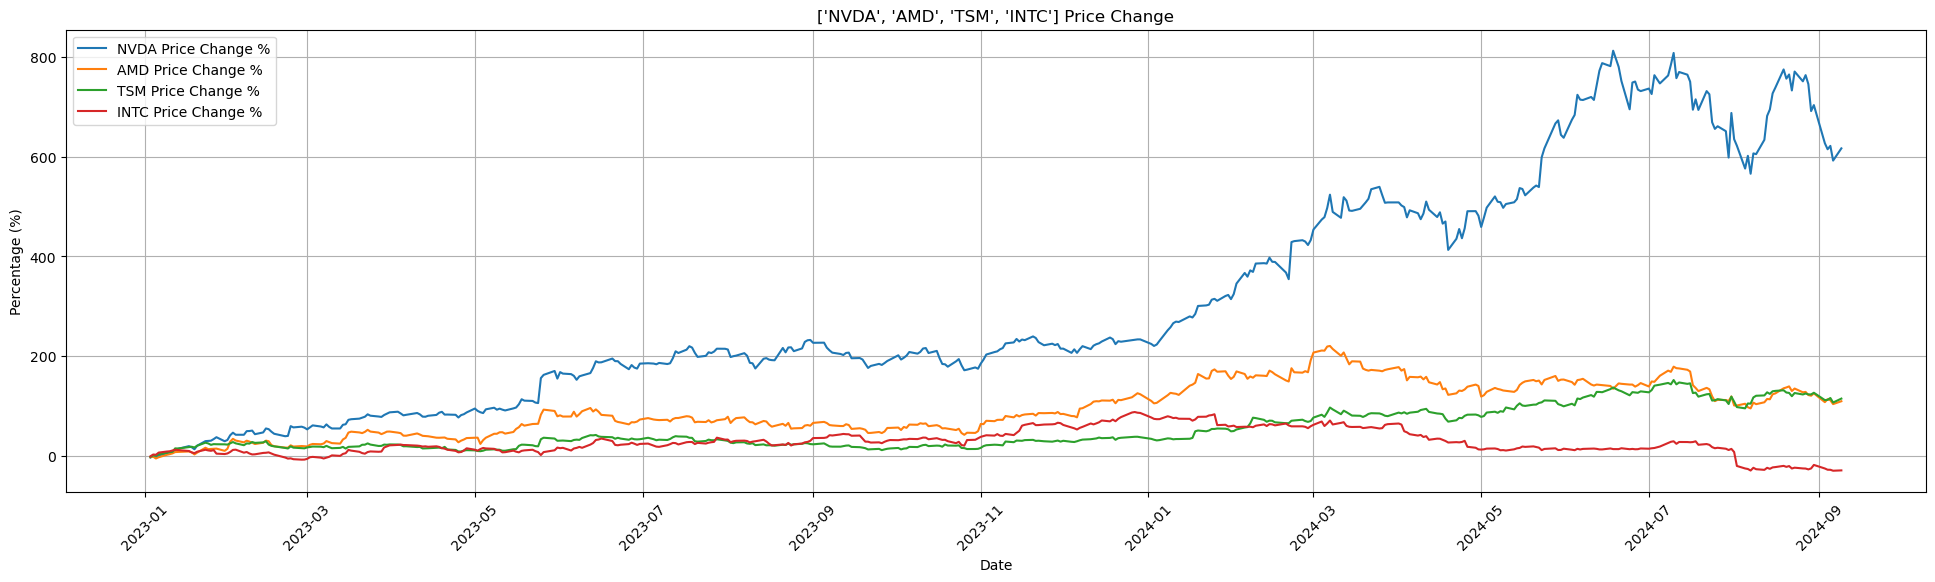

In [19]:
# Create a figure and axis for plotting
plt.figure(figsize=(24, 6))

for symbol in ticker_list:
    variable_name = symbol.replace('/', '_')  # Replace '/' with '_' to create a valid variable name

    plt.plot(locals()[f"stock_df_{variable_name}"]['date'], 
             locals()[f"stock_df_{variable_name}"]['price change %'], 
             label=f'{variable_name} Price Change %')
   
# Adding titles and labels
plt.title(f'{ticker_list} Price Change')
plt.xlabel('Date')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()  # Show legend
plt.grid()  # Show grid

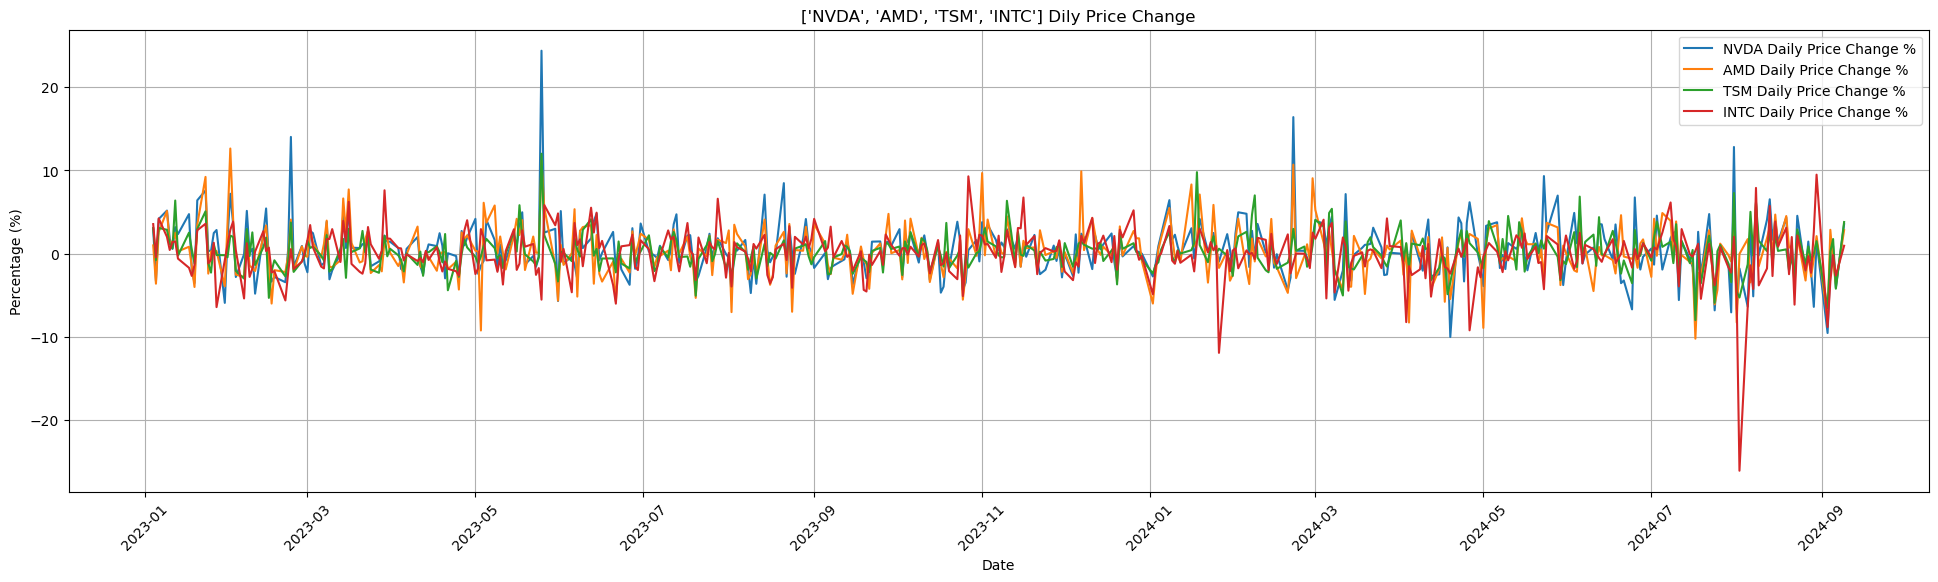

In [30]:
# Create a figure and axis for plotting
plt.figure(figsize=(24, 6))

for symbol in ticker_list:
    variable_name = symbol.replace('/', '_')  # Replace '/' with '_' to create a valid variable name

    plt.plot(locals()[f"stock_df_{variable_name}"]['date'], 
             locals()[f"stock_df_{variable_name}"]['daily change %'], 
             label=f'{variable_name} Daily Price Change %')
   
# Adding titles and labels
plt.title(f'{ticker_list} Dily Price Change')
plt.xlabel('Date')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()  # Show legend
plt.grid()  # Show grid

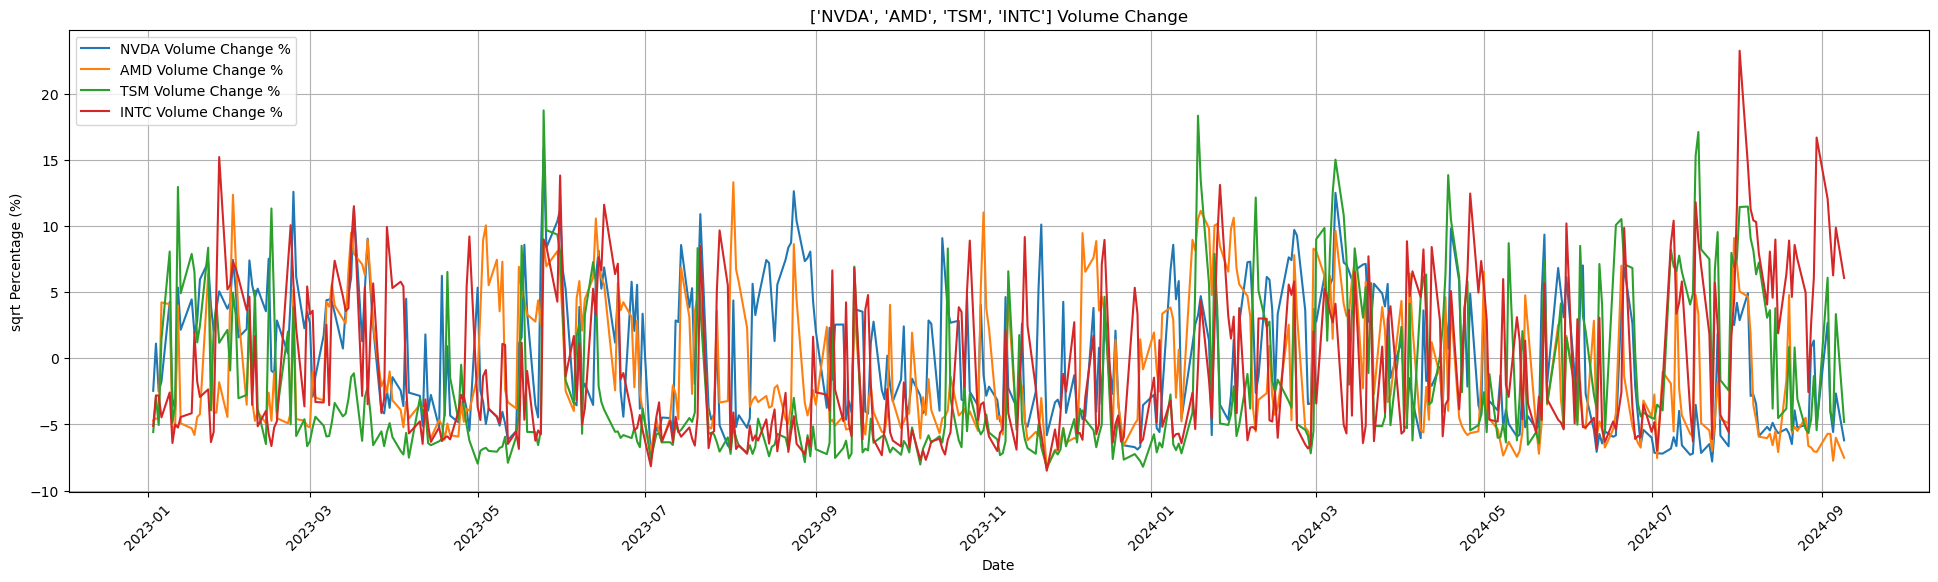

In [21]:
# Create a figure and axis for plotting
plt.figure(figsize=(24, 6))

for symbol in ticker_list:
    variable_name = symbol.replace('/', '_')  # Replace '/' with '_' to create a valid variable name

    plt.plot(locals()[f"stock_df_{variable_name}"]['date'], 
             locals()[f"stock_df_{variable_name}"]['vol_vs_average %'], 
             label=f'{variable_name} Volume Change %')
   
# Adding titles and labels
plt.title(f'{ticker_list} Volume Change')
plt.xlabel('Date')
plt.ylabel('sqrt Percentage (%)')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()  # Show legend
plt.grid()  # Show grid

In [22]:
# user input for the ticker 
ticker_index_input = input("Enter the Stock symbols (e.g., SPY, QQQ, EWU, EWJ): ")
ticker_index_list = [f"{ticker.strip()}" for ticker in ticker_index_input.split(",")]  # Format as f-string

Enter the Stock symbols (e.g., SPY, QQQ, EWU, EWJ):  SPY, QQQ, EWU, EWJ


In [23]:
def fetch_data(ticker_index_list, start_date, end_date, timeframe='1D'):
    all_data = []  # To hold DataFrames for all symbols
    
    for symbol in ticker_index_list:
        # Fetching bar data from Alpaca
        barset = api.get_bars(symbol, timeframe, start=start_date, end=end_date)
        
        # Convert the barset to a DataFrame
        bars_df = pd.DataFrame([{
            'ticker': symbol,
            'time': bar.t.strftime('%Y-%m-%d %H:%M:%S'),  # Converting timestamp to string
            'open': bar.o,
            'high': bar.h,
            'low': bar.l,
            'close': bar.c,
            'volume': bar.v
        } for bar in barset])

        # Append this symbol's DataFrame to the list
        all_data.append(bars_df)

    # Concatenate all individual DataFrames into one
    combined_df = pd.concat(all_data, ignore_index=True)

    return combined_df

# List of tickers
#print(ticker_index_list) 

# Fetching data and returning as a DataFrame
stock_index_df = fetch_data(ticker_index_list, start_date, end_date)

# Dynamically create DataFrames for each symbol
for symbol in ticker_index_list:
    variable_name = symbol.replace('/', '_')  # Replace '/' with '_' to create a valid variable name
    stock_index_df.loc[:,'date'] = pd.to_datetime(stock_index_df.loc[:,'time']).dt.date
    clean_stock_index_df = stock_index_df.copy()[['ticker', 'date', 'open', 'close', 'volume']]
    globals()[f"{variable_name}_df"] = clean_stock_index_df[clean_stock_index_df['ticker'] == symbol]
#    print(f"\nDataFrame for {symbol}:\n", globals()[f"{variable_name}_df"])

In [24]:
for symbol in ticker_index_list:
    variable_name = symbol.replace('/', '_')  # Replace '/' with '_' to create a valid variable name
    stock_index_df_calc = globals()[f"{variable_name}_df"].copy()  # Make sure to use .copy() to avoid SettingWithCopyWarning
              
    # Run calculations     
    stock_first_open = stock_index_df_calc['open'].iloc[0]
    stock_close = stock_index_df_calc['close']
    stock_open = stock_index_df_calc['open']
    price_change = ((stock_close - stock_first_open) / stock_first_open) * 100
    prev_close = stock_index_df_calc['close'].shift(1)
    daily_change = ((stock_close - prev_close) / prev_close) * 100
    weights = stock_index_df_calc['close']
    volume = stock_index_df_calc['volume']
    average_volume_stock = (volume * weights).sum() / weights.sum()
    volume_change = (((volume - average_volume_stock) / average_volume_stock) * 100)
    
    # to decrease the volume change range to manageable levels
    sqrt_volume_change = np.sqrt(np.abs(volume_change))

    # to retain the sign of the original volume change (positive or negative), you can reapply the sign
    sqrt_volume_change = np.sign(volume_change) * sqrt_volume_change

    # Use .loc[] to assign the new calculated columns
    stock_index_df_calc.loc[:,'price change %'] = price_change
    stock_index_df_calc.loc[:,'daily change %'] =  daily_change
    stock_index_df_calc.loc[:,'vol_vs_average %'] = sqrt_volume_change
    
    # Store the DataFrame with the new name
    locals()[f"stock_index_df_{variable_name}"] = stock_index_df_calc
    
    # Print out the DataFrame
#    print(f"\nDataFrame for {variable_name}:\n", locals()[f"stock_index_df_{variable_name}"])

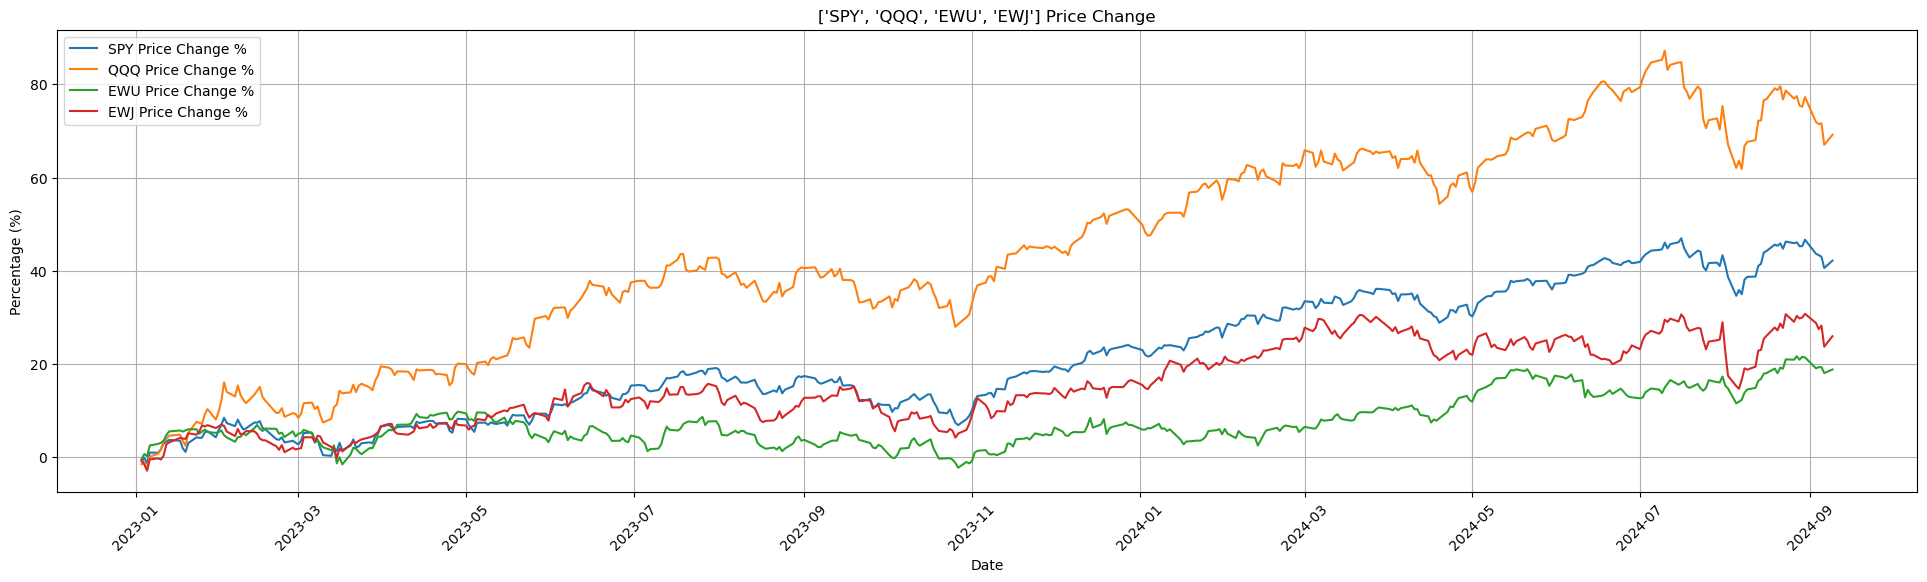

In [25]:
# Create a figure and axis for plotting
plt.figure(figsize=(24, 6))

for symbol in ticker_index_list:
    variable_name = symbol.replace('/', '_')  # Replace '/' with '_' to create a valid variable name

    plt.plot(locals()[f"stock_index_df_{variable_name}"]['date'], 
             locals()[f"stock_index_df_{variable_name}"]['price change %'], 
             label=f'{variable_name} Price Change %')
   
# Adding titles and labels
plt.title(f'{ticker_index_list} Price Change')
plt.xlabel('Date')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()  # Show legend
plt.grid()  # Show grid

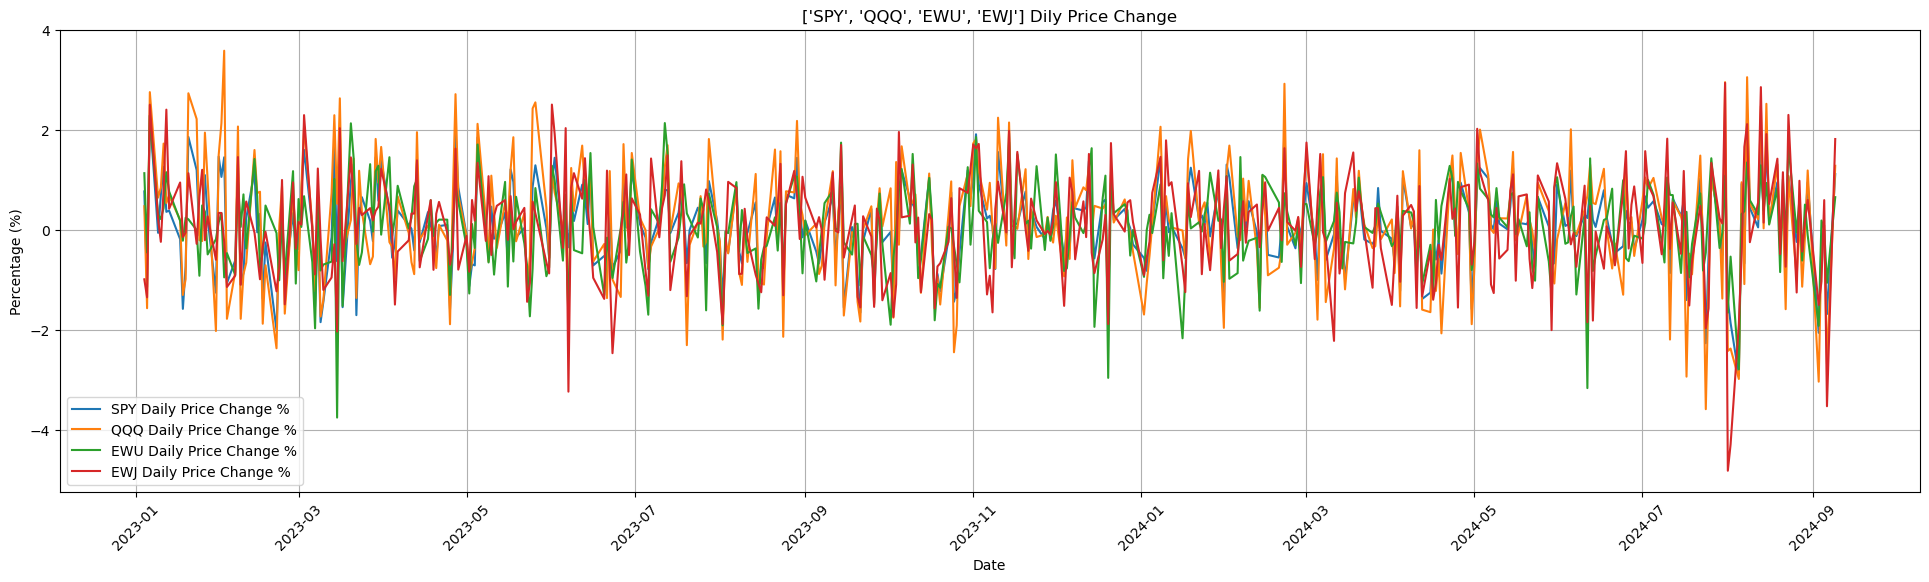

In [26]:
# Create a figure and axis for plotting
plt.figure(figsize=(24, 6))

for symbol in ticker_index_list:
    variable_name = symbol.replace('/', '_')  # Replace '/' with '_' to create a valid variable name

    plt.plot(locals()[f"stock_index_df_{variable_name}"]['date'], 
             locals()[f"stock_index_df_{variable_name}"]['daily change %'], 
             label=f'{variable_name} Daily Price Change %')
   
# Adding titles and labels
plt.title(f'{ticker_index_list} Dily Price Change')
plt.xlabel('Date')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()  # Show legend
plt.grid()  # Show grid

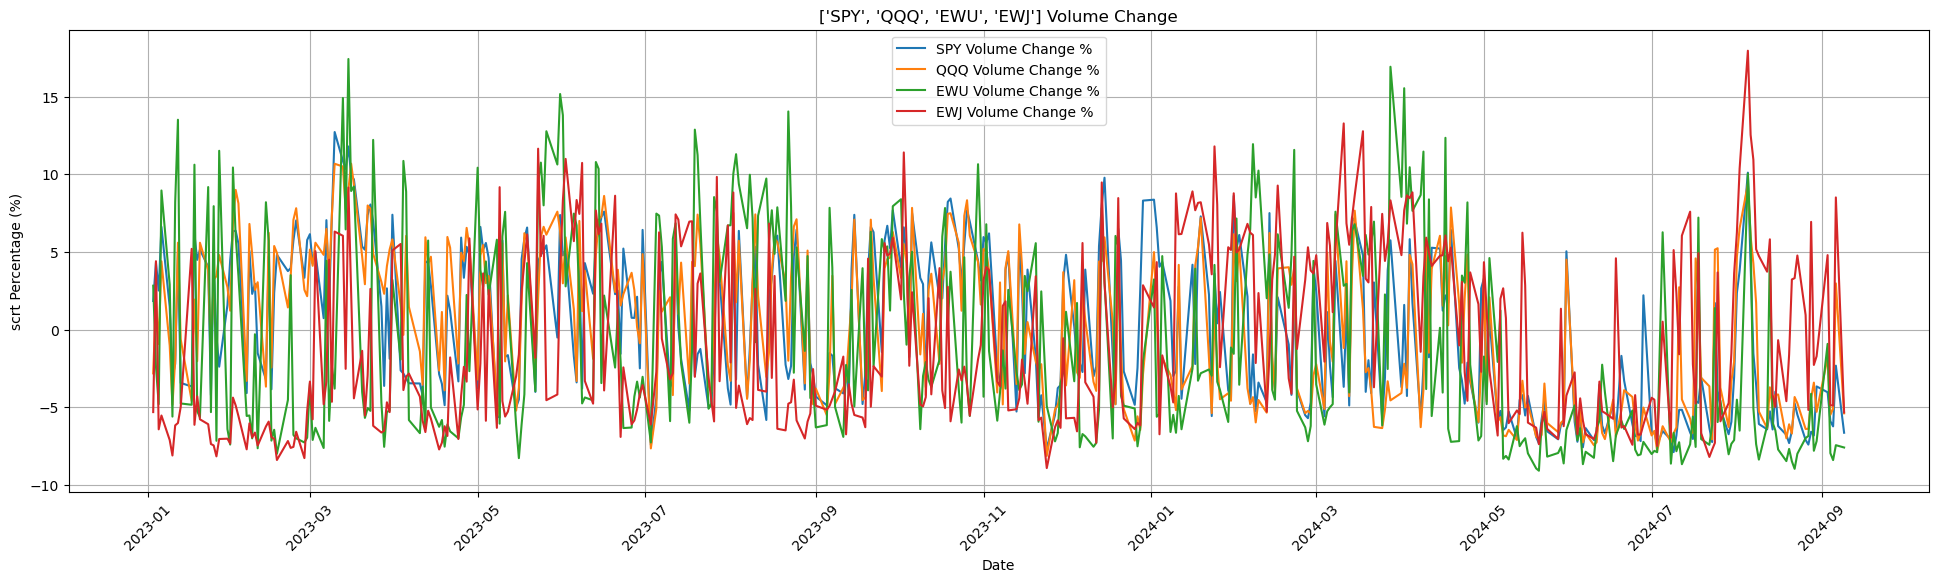

In [35]:
# Create a figure and axis for plotting
plt.figure(figsize=(24, 6))

for symbol in ticker_index_list:
    variable_name = symbol.replace('/', '_')  # Replace '/' with '_' to create a valid variable name

    plt.plot(locals()[f"stock_index_df_{variable_name}"]['date'], 
             locals()[f"stock_index_df_{variable_name}"]['vol_vs_average %'], 
             label=f'{variable_name} Volume Change %')
   
# Adding titles and labels
plt.title(f'{ticker_index_list} Volume Change')
plt.xlabel('Date')
plt.ylabel('scrt Percentage (%)')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()  # Show legend
plt.grid()  # Show grid

In [48]:
# Create a custom plot
while True:
    try:
        # Get user input for the symbols and the type of plot
        custom_symbols = input("Enter cryptocurrency, stock, or index symbols (e.g., BTC/USD, NVDA, SPY) separated by commas, or type 'exit' to quit: ").upper()
        
        if custom_symbols == 'EXIT':
            print("Exiting the program.")
            break  # Exit the loop if the user types 'exit'
        
        custom_plot = input("Enter the graph you want: Price Change = P, Daily Price Change = D, Volume Change = V: ").upper()

        # Split the input string by commas to get a list of symbols
        symbol_list = [symbol.strip() for symbol in custom_symbols.split(',')]
        
        # Initialize the plot
        plt.figure(figsize=(24, 6))
        
        # Loop over each symbol and plot on the same graph
        for custom_symbol in symbol_list:
            # Check if the symbol belongs to cryptocurrency, stock, or index list and assign the correct DataFrame
            if custom_symbol in unique_symbols:
                custom_symbol_cleaned = custom_symbol.replace('/', '_')
                plot_df = locals().get(f"crypto_df_{custom_symbol_cleaned}")
            elif custom_symbol in ticker_list:
                plot_df = locals().get(f"stock_df_{custom_symbol}")
            elif custom_symbol in ticker_index_list:
                plot_df = locals().get(f"stock_index_df_{custom_symbol}")
            else:
                print(f"Symbol '{custom_symbol}' not found")
                continue  # Skip this symbol if not found
            
            # Proceed only if a valid DataFrame is found
            if plot_df is not None:
                # Determine the type of graph based on the user's input
                if custom_plot == 'P':
                    plt.plot(plot_df['date'], plot_df['price change %'], label=f'{custom_symbol} Price Change %')
                elif custom_plot == 'D':
                    plt.plot(plot_df['date'], plot_df['daily change %'], label=f'{custom_symbol} Daily Price Change %')
                elif custom_plot == 'V':
                    plt.plot(plot_df['date'], plot_df['vol_vs_average %'], label=f'{custom_symbol} Volume Change %')
                else:
                    print("Invalid plot type selected")
                    continue  # Skip this iteration if an invalid plot type is selected

        # Display the graph with all the symbols plotted on the same figure
        if plt.get_fignums():  # Only show the plot if a valid plot was created
            plt.title(f'Comparison of {", ".join(symbol_list)}')
            plt.xlabel('Date')
            plt.ylabel('Percentage (%)')
            plt.xticks(rotation=45)
            plt.legend()
            plt.grid()
            plt.show()

    except Exception as e:
        print(f"An error occurred: {e}")

    # After each graph, ask the user if they want to input more or quit
    #continue_input = input("Do you want to plot another graph? (Y to continue, N to exit): ").lower()
    #if continue_input != 'y':
        #print("Exiting the program.")
        #break

Enter cryptocurrency, stock, or index symbols (e.g., BTC/USD, NVDA, SPY) separated by commas, or type 'exit' to quit:  exit


Exiting the program.


Enter cryptocurrency, stock, or index symbols (e.g., BTC/USD, NVDA, SPY) separated by commas, or type 'exit' to quit:  BTC/USD, NVDA, SPY
Enter the graph you want: Price Change = P, Daily Price Change = D, Volume Change = V:  p


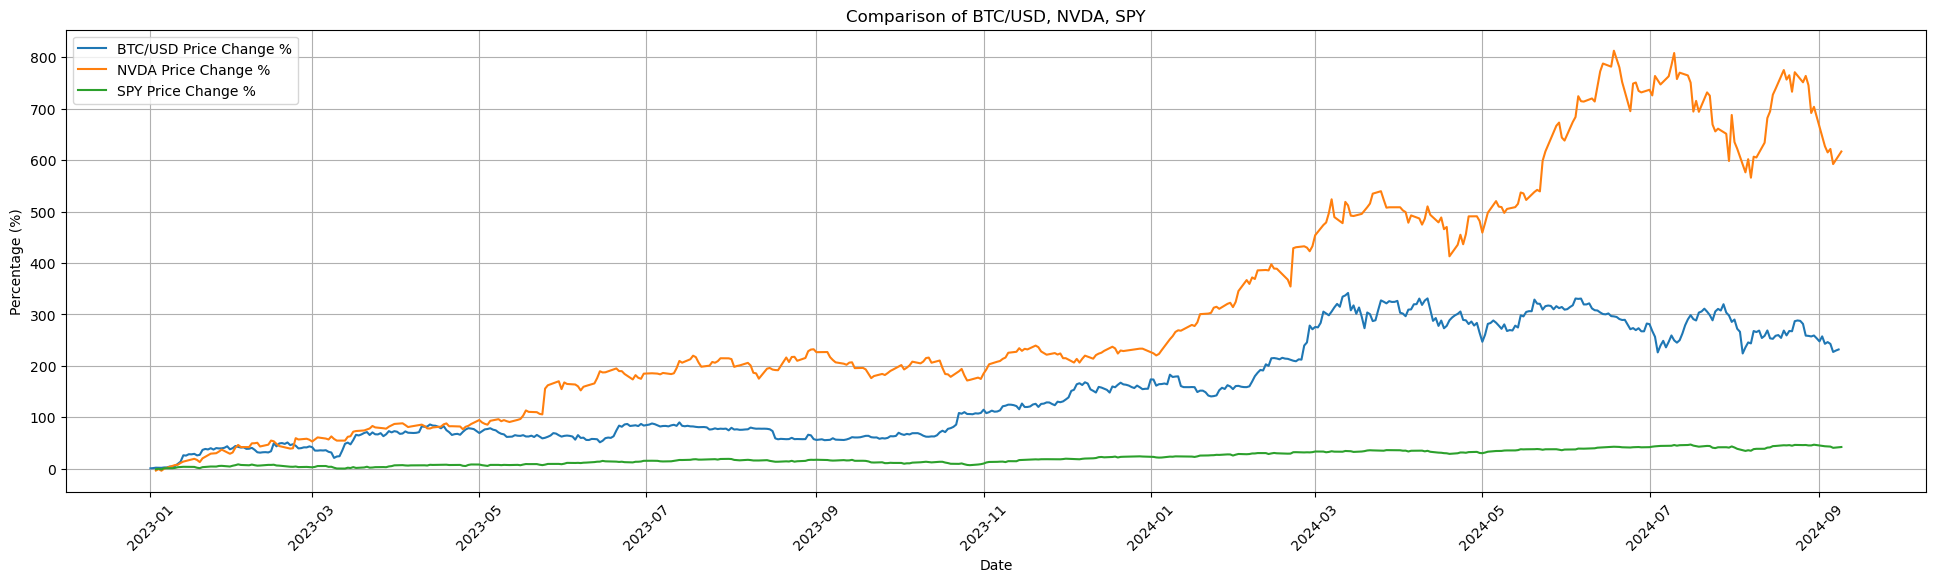

Enter cryptocurrency, stock, or index symbols (e.g., BTC/USD, NVDA, SPY) separated by commas, or type 'exit' to quit:  BTC/USD, NVDA, SPY
Enter the graph you want: Price Change = P, Daily Price Change = D, Volume Change = V:  D


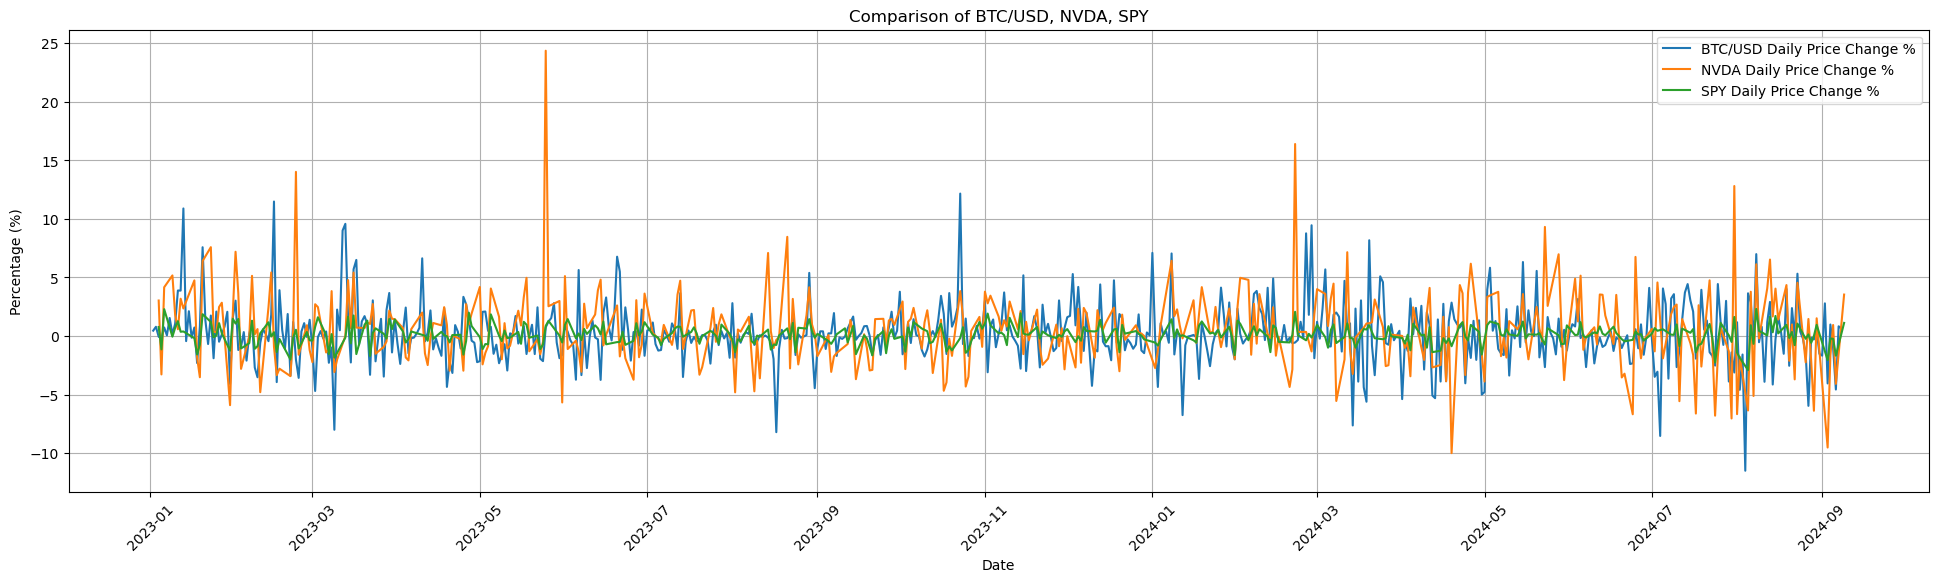

Enter cryptocurrency, stock, or index symbols (e.g., BTC/USD, NVDA, SPY) separated by commas, or type 'exit' to quit:  BTC/USD, NVDA, SPY
Enter the graph you want: Price Change = P, Daily Price Change = D, Volume Change = V:  v


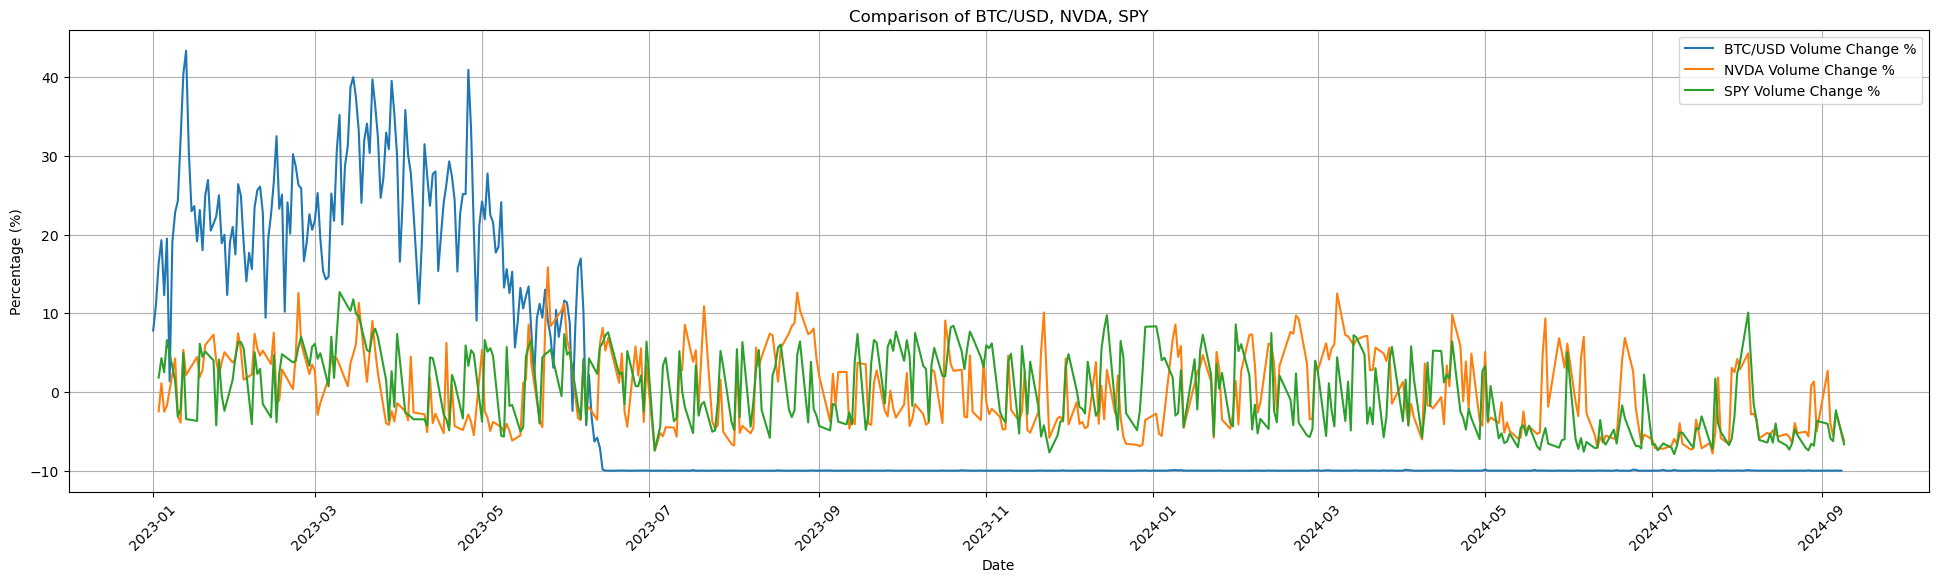

In [ ]:
# Create a custom plot
while True:
    try:
        # Get user input for the symbols and the type of plot
        custom_symbols = input("Enter cryptocurrency, stock, or index symbols (e.g., BTC/USD, NVDA, SPY) separated by commas, or type 'exit' to quit: ").upper()
        
        if custom_symbols == 'EXIT':
            print("Exiting the program.")
            break  # Exit the loop if the user types 'exit'
        
        custom_plot = input("Enter the graph you want: Price Change = P, Daily Price Change = D, Volume Change = V: ").upper()

        # Split the input string by commas to get a list of symbols
        symbol_list = [symbol.strip() for symbol in custom_symbols.split(',')]
        
        # Initialize the plot (only once)
        plt.figure(figsize=(24, 6))
        
        # Loop over each symbol and plot them on the same grid
        for custom_symbol in symbol_list:
            # Check if the symbol belongs to cryptocurrency, stock, or index list and assign the correct DataFrame
            if custom_symbol in unique_symbols:
                custom_symbol_cleaned = custom_symbol.replace('/', '_')
                plot_df = locals().get(f"crypto_df_{custom_symbol_cleaned}")
            elif custom_symbol in ticker_list:
                plot_df = locals().get(f"stock_df_{custom_symbol}")
            elif custom_symbol in ticker_index_list:
                plot_df = locals().get(f"stock_index_df_{custom_symbol}")
            else:
                print(f"Symbol '{custom_symbol}' not found")
                continue  # Skip this symbol if not found
            
            # Proceed only if a valid DataFrame is found
            if plot_df is not None:
                # Determine the type of graph based on the user's input
                if custom_plot == 'P':
                    plt.plot(plot_df['date'], plot_df['price change %'], label=f'{custom_symbol} Price Change %')
                elif custom_plot == 'D':
                    plt.plot(plot_df['date'], plot_df['daily change %'], label=f'{custom_symbol} Daily Price Change %')
                elif custom_plot == 'V':
                    plt.plot(plot_df['date'], plot_df['vol_vs_average %'], label=f'{custom_symbol} Volume Change %')
                else:
                    print("Invalid plot type selected")
                    continue  # Skip this iteration if an invalid plot type is selected

        # Display the graph with all the symbols plotted on the same figure
        if plt.get_fignums():  # Only show the plot if a valid plot was created
            plt.title(f'Comparison of {", ".join(symbol_list)}')
            plt.xlabel('Date')
            plt.ylabel('Percentage (%)')
            plt.xticks(rotation=45)
            plt.legend()  # Display the legend showing different symbols
            plt.grid(True)  # Enable grid lines
            plt.show()

    except Exception as e:
        print(f"An error occurred: {e}")